In [207]:
import sys
sys.path.append('../')

import gc
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats

#from sa_decomp_layer import SADecompLayer



import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet152, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp
from glob import glob


from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset, AUTOTUNE
from imagenet_utils.imagenet_clsloc2 import clsloc
from imagenet_utils.load_images import load_images
from imagenet_utils.preprocess import preprocess

from utils.utils import *

import keras
from keras import layers

from keras import backend as K

import scienceplots

from activation_maximization import showall, getAM

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [208]:
gc.collect()
model = VGG16(weights='imagenet',
				  include_top=True,
				  input_shape=(224, 224, 3))



In [209]:
LAYER =-1

In [210]:
top10KF = topKfilters(model, LAYER, k=20)   #Find the top 20% filters to look at
print(top10KF)

[70, 351, 268, 115, 13, 286, 476, 134, 484, 329, 435, 200, 144, 60, 145, 167, 364, 501, 66, 349, 141, 126, 370, 481, 473, 404, 158, 437, 29, 490, 247, 411, 348, 318, 310, 197, 213, 325, 92, 403, 1, 143, 90, 97, 366, 314, 478, 137, 459, 376, 44, 54, 410, 467, 299, 301, 377, 203, 357, 305, 38, 243, 446, 494, 400, 111, 322, 313, 140, 251, 135, 295, 139, 431, 426, 10, 208, 358, 317, 462, 353, 383, 396, 8, 198, 304, 190, 397, 355, 31, 64, 0, 185, 368, 6, 151, 122, 171, 37, 408, 466, 311]


In [211]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)
			
layer_num = model.layers.index(conv_layers[LAYER])
layer_num_p = layer_num-1

In [212]:
F = 46#top10KF[0]

In [213]:
origAM, scaledAM = getAM(model, LAYER, F )
modified_model = keras.models.Model(
	model.inputs, [model.layers[layer_num_p].output, model.layers[layer_num].output, model.output]
)

f2, f1, preds = modified_model(tf.expand_dims(origAM, axis=0), training=False)
f2_mean_act = tf.math.reduce_mean(f2, axis=(0,1,2))


block5_conv3


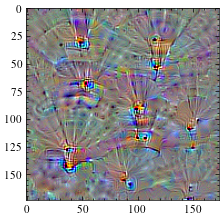

In [214]:

plt.imshow(tf.keras.utils.array_to_img(scaledAM))

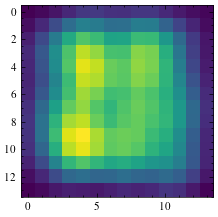

In [215]:
plt.imshow(f1[0,...,F])

In [216]:
def rotate (model_original, layers)  :
	model = tf.keras.models.clone_model(model_original)
	model.set_weights(model_original.get_weights())
	conv_layers = []
	for l in model.layers:
		if 'conv2d' in str(type(l)).lower():
			if l.kernel_size == (3,3) or l.kernel_size == (7,7):
				conv_layers.append(l)
				print(l)
	for l in layers:
		filters, biases = conv_layers[l].get_weights()
		print(conv_layers[l].name)
		# Reshape weights to (64 * 128, 3, 3) for batch processing
		k = filters.shape[0]
		weights_reshaped = tf.reshape(filters, (k, k,-1))

		rotated_weights = tf.image.rot90(weights_reshaped, k=1)
		rotated_weights = tf.reshape(rotated_weights, (k, k,filters.shape[-2],filters.shape[-1]))
		
		conv_layers[l].set_weights([rotated_weights, biases])


	return model


block5_conv3
block5_conv3


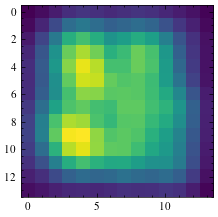

In [217]:
model_rot = rotate(model, [-1])
'''model_rot.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),            
			metrics=[
				keras.metrics.CategoricalAccuracy(name="accuracy"),
				keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),])'''

origAMR, scaledAMR = getAM(model_rot, LAYER, F )
modified_model = keras.models.Model(
	model_rot.inputs, [model_rot.layers[layer_num_p].output, model_rot.layers[layer_num].output, model_rot.output]
)

f2R, f1R, predsR = modified_model(tf.expand_dims(origAM, axis=0), training=False)
plt.imshow(f1R[0,...,F])

(array([25., 33., 15., 21., 16., 11., 23., 32., 13.,  7.]),
 array([ 0.5153503,  4.732367 ,  8.949384 , 13.1664   , 17.383417 ,
        21.600433 , 25.81745  , 30.034466 , 34.251484 , 38.4685   ,
        42.685516 ], dtype=float32),
 <BarContainer object of 10 artists>)

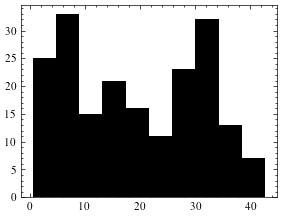

In [218]:
plt.hist(tf.reshape(f1[...,F], (-1)).numpy())

(array([27., 33., 15., 22., 13., 16., 22., 32., 10.,  6.]),
 array([ 0.5441674,  4.878705 ,  9.2132435, 13.547781 , 17.882318 ,
        22.216856 , 26.551394 , 30.885933 , 35.22047  , 39.555008 ,
        43.889545 ], dtype=float32),
 <BarContainer object of 10 artists>)

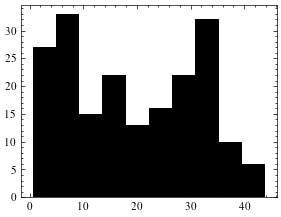

In [219]:
plt.hist(tf.reshape(f1R[...,F], (-1)).numpy())

(3, 3, 512, 512)
(512,)


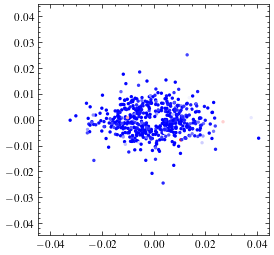

In [220]:
filters = get_filter(model_rot, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act)

ax.scatter(x,y, c=color, cmap = 'bwr', s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

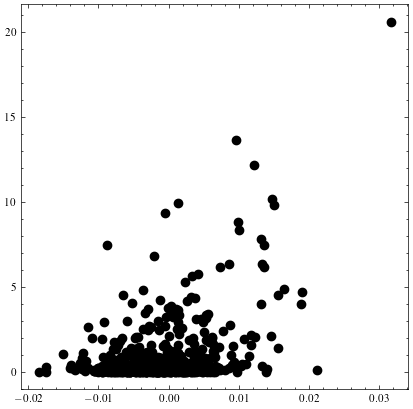

In [221]:
domOrr = getDominantAngle(get_filter(model, LAYER)-1)
kernOrr = getSobelTF(filters)[:,F]
orrSim = domOrr - kernOrr  #orrientation similarity
orrSim  = np.arctan2(np.sin(orrSim), np.cos(orrSim))  #Wrap values -pi to pi
color =  matplotlib.colors.Normalize(vmin=-np.pi, vmax=np.pi)(orrSim)

fig,ax  = plt.subplots(1,1,figsize=(5,5))
dc = np.mean(filters, axis=(0,1))

ax.scatter(dc[:,F], f2_mean_act)


(-3.1213910579681396, 3.088611125946045)
-3.141592653589793
['-$\\pi$', '0', '$\\pi$']


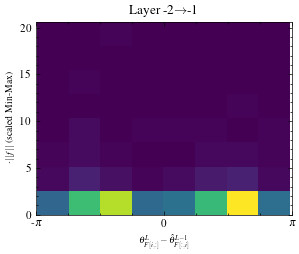

In [222]:
fig, ax= plt.subplots(1,1)

data = orrSim
 # (np.array(cos_sim) + np.pi) % (2 * np.pi) - np.pi
ax.hist2d(data,f2_mean_act, bins=8)#, weights=weight)
print(ax.get_xlim())
data_min, data_max = np.min(data), np.max(data)

# Set the tick marks at intervals of π
tick_min = np.floor(data_min / np.pi) * np.pi  # Start at the lowest multiple of π
tick_max = np.ceil(data_max / np.pi) * np.pi    # End at the highest multiple of π
ticks = np.arange(tick_min, tick_max + np.pi, np.pi)  # Ticks spaced by π
print(tick_min)
# Format tick labels with π notation
labels = [f"{int(t / np.pi)}π" if t != 0 else "0" for t in ticks]
labels = [label.replace("π", "$\\pi$").replace("1$\\pi$", "$\\pi$") for label in labels]
print(labels)
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels)




#ax.convert_xunits(radians)
ax.set_ylabel(r"$\cdot ||f||$ (scaled Min-Max)", fontsize=7)
#ax.set_ylabel(r"Count", fontsize=7)
ax.set_xlabel(r"$\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]}$", fontsize=7)
ax.set_title(f"Layer {LAYER-1}"+r"$\rightarrow$"+f"{LAYER}")


plt.show() 

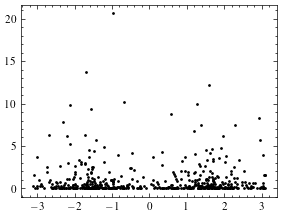

In [223]:
fig, ax= plt.subplots(1,1)

ax.scatter(orrSim, f2_mean_act, s=1)

(3, 3, 512, 512)
(200,)


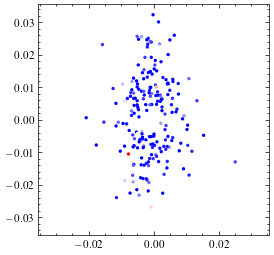

In [224]:
posChannels = tf.where(tf.greater(np.sign(dc[:,F]),0))[:,0].numpy()
posChannels
filters = get_filter(model, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()[posChannels]
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()[posChannels]
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act.numpy()[posChannels])

ax.scatter(x,y, c=color, cmap = 'bwr', s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

(3, 3, 512, 512)
(512,)


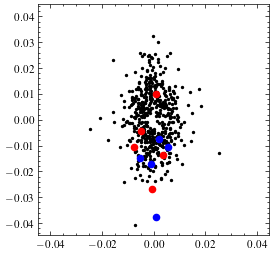

In [225]:
negChannels = tf.where(tf.less(np.sign(dc[:,F]),0))[:,0].numpy()
negChannels
filters = get_filter(model, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

topAct = tf.argsort(f2_mean_act, direction='DESCENDING').numpy()#[:, top10F.indices.numpy()]
top10channels = topAct[np.isin( topAct, posChannels )]
top10channels = top10channels[:5]

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()#[negChannels]
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()#[negChannels]
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act.numpy())



ax.scatter(x,y, c='black', cmap = 'bwr', s=2)
ax.scatter(x[top10channels],y[top10channels], c='red', cmap = 'bwr', s=20)
top10channels = topAct[np.isin( topAct, negChannels )]
top10channels = top10channels[:5]
ax.scatter(x[top10channels],y[top10channels], c='blue', cmap = 'bwr', s=20)

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

(array([136.,  36.,  14.,   5.,   5.,   2.,   1.,   0.,   0.,   1.]),
 array([  0.      ,  36.542007,  73.084015, 109.62602 , 146.16803 ,
        182.71004 , 219.25204 , 255.79405 , 292.33606 , 328.87805 ,
        365.42007 ], dtype=float32),
 <BarContainer object of 10 artists>)

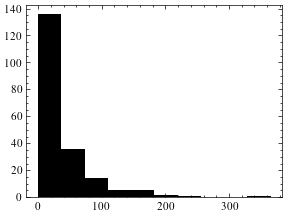

In [226]:
plt.hist(tf.math.reduce_euclidean_norm(f2, axis=(0,1,2)).numpy()[posChannels])

(array([214.,  59.,  17.,  13.,   5.,   0.,   2.,   1.,   0.,   1.]),
 array([  0.      ,  17.062132,  34.124264,  51.186398,  68.24853 ,
         85.31066 , 102.372795, 119.43493 , 136.49706 , 153.55919 ,
        170.62132 ], dtype=float32),
 <BarContainer object of 10 artists>)

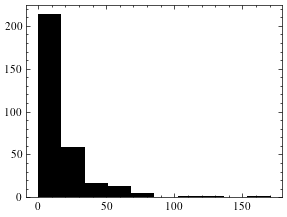

In [227]:
plt.hist(tf.math.reduce_euclidean_norm(f2, axis=(0,1,2)).numpy()[negChannels])

In [228]:
topAct = tf.argsort(f2_mean_act, direction='DESCENDING').numpy()#[:, top10F.indices.numpy()]
topAct[np.isin( topAct, posChannels )]

array([112, 422, 225, 396, 415, 159, 356, 491, 202, 206, 132, 169, 370,
       449, 400, 362, 385, 267, 211,  96, 210, 473, 182, 272, 382, 317,
       229, 343, 205, 484,  48, 451, 222, 465,  65, 113, 399, 421, 120,
       489,  63, 122, 490, 126,  17, 218, 181,  41, 361,  13, 156, 260,
       328, 158,  27, 493,  68, 100, 398, 134, 482, 207, 485, 335, 235,
       274,  25,  50, 282, 291,   7,  95, 472, 308, 227, 124, 501, 466,
       193, 373, 378, 386, 301, 303, 189, 412, 304, 148, 497, 322, 116,
        92, 186,  93, 257, 177, 336, 269, 369, 374, 436,  33, 123, 416,
        45,  36,  23,  71, 296,  16,  53, 154, 434, 224, 170, 141, 101,
       409, 420, 153, 165, 286, 263,  62, 194, 395, 330,   1, 155, 104,
       479, 348, 171, 426,  28, 237, 392, 142, 349,  55,  61, 228,   9,
       346, 188, 486, 456, 402, 133, 480, 344, 115, 315,  30, 231, 463,
         8, 502, 379, 197, 333, 332,  64, 119, 248, 397, 245,  70, 250,
       209, 452, 230, 261, 196, 137, 232, 353, 492, 393, 309,  7

In [229]:
topAct[np.isin( topAct, negChannels )]

array([246, 131,  69, 366, 471, 363, 265, 390, 321, 203, 499, 254,  89,
       215, 413, 151, 448, 256, 312, 478,  19, 437, 367,  74, 226, 476,
       326, 114, 474, 167, 294, 198, 355, 212, 314,  97, 105,  80, 102,
       381, 505, 453, 323, 391, 146,  40, 351,  83, 240, 244, 241, 467,
       444, 458, 433,  37, 173, 447, 510, 443, 259, 149, 117, 238, 338,
       125, 407, 320,  10, 427, 275, 219, 217, 164, 503, 354, 110, 273,
       364,  51, 290, 150,  35, 457, 147, 430,  31, 325, 495, 455, 371,
       306,  15, 439,  14,   0,  90,  20, 388, 243, 187, 192,  91,  88,
       190, 329,  44, 383, 498,  79, 277, 247, 160,  34, 417, 316, 375,
        72, 372, 180, 292, 347,  29, 509,  11, 440, 157, 462, 271, 504,
       442,  77, 494, 405, 500,  85, 461, 136, 339, 239,  26, 285, 287,
       310, 342, 140, 428, 221, 488, 280, 293, 130, 394, 162, 487, 496,
       331, 337, 200, 111, 414, 341,  58,  52, 163, 251, 477,  46, 418,
       377, 108, 410, 176, 454, 172,  94, 121, 129,  82, 345,  5

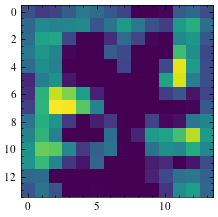

In [230]:
plt.imshow(f2[0,..., 226])

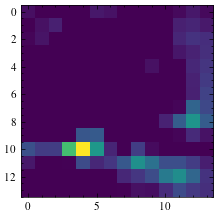

In [231]:
plt.imshow(f2[0,..., 189])

(3, 3, 512, 512)
(512,)


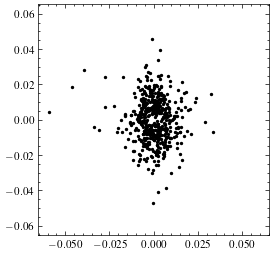

In [232]:
F_p = topAct[np.isin( topAct, posChannels )][-1]
filters = get_filter(model, LAYER-1)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F_p]*np.cos((theta[:,F_p]))).numpy()
y = (a_mag[:,F_p]*np.sin((theta[:,F_p]))).numpy()
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))

ax.scatter(x,y , s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)